In [ ]:
!pip install GPyOpt --quiet
!pip install GPy --quiet

In [2]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

In [4]:
#dataset = UCI Car Evaluation
names=['buying','maint','doors','persons','lug_boot','safety','class']
df = pd.read_csv('car.data', names = names)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

In [6]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [7]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [8]:
#Random Forest classification

#max_features: 1 to around sqrt(# of features of dataset)
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 5)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (2, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  return score

In [9]:
def BO(model,kernel):
  optimizer = GPyOpt.methods.BayesianOptimization(f=model, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )
  optimizer.run_optimization(max_iter=100)
  #maximum accuracy score
  acc_max=optimizer.fx_opt
  #best parameters
  params_best=optimizer.x_opt
  print(acc_max)
  print(params_best)
  optimizer.plot_convergence()
  optimizer.plot_acquisition()

In [17]:
p1 = [1,2,3,4,5]
p2 = np.linspace(1,200,101)
x,y = np.meshgrid(p1,p2)
scorelist=[]

for i in range(len(p1)):
  for j in range(len(p2)):
    clf = RandomForestClassifier(max_features=p1[i],n_estimators=int(p2[j]))
    clf.fit(X_train,y_train)
    score = kfold_score(clf,X_train, y_train,10)
    scorelist.append(score)

Text(0, 0.5, 'n_neighbors')

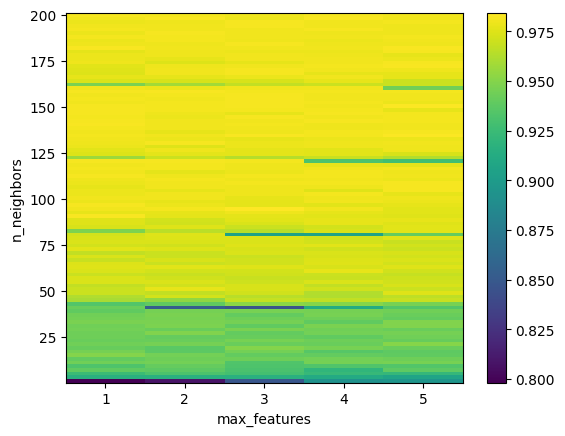

In [22]:
z=x*y
scorelist=np.reshape(scorelist,z.shape)
fig, ax = plt.subplots()
plot1 = ax.pcolormesh(x, y, scorelist)
fig.colorbar(plot1, ax=ax)
plt.xlabel("max_features")
plt.ylabel("n_neighbors")

In [27]:
y.shape

(101, 5)

In [30]:

kernel1 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3
model = GPy.models.GPRegression(y, scorelist, kernel)
model.optimize(messages=True)
print(model)
model.plot(figsize=(5, 3));


Name : GP regression
Objective : -1378.7457432485417
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  GP_regression.               |                  value  |  constraints  |  priors
  sum.Mat52.variance           |     0.2599828259459052  |      +ve      |        
  sum.Mat52.lengthscale        |     122.36806687822231  |      +ve      |        
  sum.Mat52_1.variance         |     0.2599828259459052  |      +ve      |        
  sum.Mat52_1.lengthscale      |     122.36806687822231  |      +ve      |        
  sum.mul.Mat52.variance       |  2.544215605419172e-19  |      +ve      |        
  sum.mul.Mat52.lengthscale    |      4.539346722722143  |      +ve      |        
  sum.mul.Mat52_1.variance     |  2.544215605419172e-19  |      +ve      |        
  sum.mul.Mat52_1.lengthscale  |      4.539346722722143  |      +ve      |        
  Gaussian_noise.variance      |  0.0001276049674613368  |      +ve      |        


TypeError: ignored